In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../dataset/NewYork_365.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract features from the 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute

# Create time-based features
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
# Assume you have a predefined list of holidays
holidays = pd.to_datetime(['2024-01-01', '2024-12-25'])  # Example holidays
df['Is_Holiday'] = df['Date'].apply(lambda x: 1 if x in holidays else 0)

In [4]:
df = df.drop(columns=['Hour', 'Minute']).reset_index(drop=True)

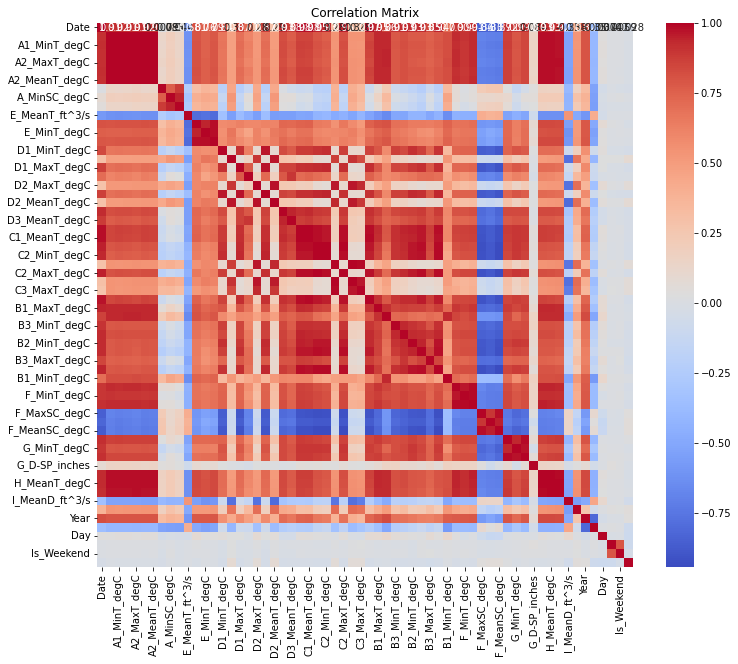

In [5]:
correlation_matrix = df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Ensemble Model for feature selection

In [6]:
ndf = df.drop(columns=['Date']).reset_index(drop=True)

In [7]:
# daily instantaneous Gage height is target as it is the level of basin depth

features = ndf.drop(columns=['J_D-IGH_ft'])  
target = ndf['J_D-IGH_ft'] 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3.8635135135122126e-05


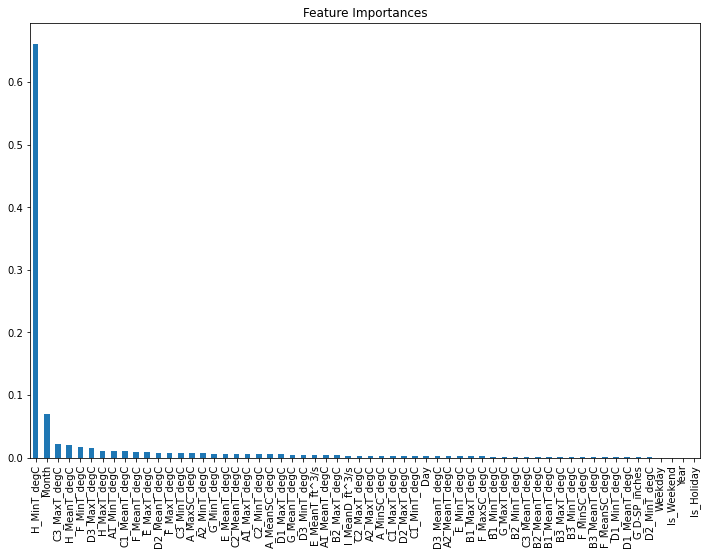

Important features based on Random Forest:
H_MinT_degC       6.613711e-01
Month             6.972612e-02
C3_MaxT_degC      2.239224e-02
H_MeanT_degC      1.974742e-02
F_MinT_degC       1.740590e-02
D3_MaxT_degC      1.579664e-02
H_MaxT_degC       1.041183e-02
A1_MinT_degC      1.025257e-02
C1_MeanT_degC     1.013457e-02
F_MeanT_degC      9.802438e-03
E_MaxT_degC       8.716067e-03
D2_MeanT_degC     7.668481e-03
F_MaxT_degC       7.371595e-03
C3_MinT_degC      7.140244e-03
A_MaxSC_degC      6.899924e-03
A2_MinT_degC      6.675761e-03
G_MinT_degC       6.078782e-03
E_MeanT_degC      5.697303e-03
C2_MeanT_degC     5.650771e-03
A1_MaxT_degC      5.563427e-03
C2_MinT_degC      5.471506e-03
A_MeanSC_degC     5.180477e-03
D1_MaxT_degC      5.075221e-03
G_MeanT_degC      4.977380e-03
D3_MinT_degC      4.496394e-03
E_MeanT_ft^3/s    3.927620e-03
A1_MeanT_degC     3.924192e-03
B2_MaxT_degC      3.718741e-03
I_MeanD_ft^3/s    2.966358e-03
C2_MaxT_degC      2.938860e-03
A2_MaxT_degC      2.769976e

In [11]:
# Get feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Display important features
print("Important features based on Random Forest:")
print(feature_importances)

Threshold calculation

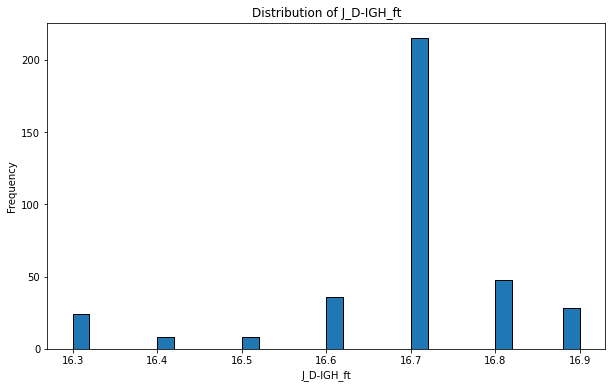

In [12]:
import matplotlib.pyplot as plt

# Plot histogram of J_D-IGH_ft values
plt.figure(figsize=(10, 6))
plt.hist(ndf['J_D-IGH_ft'], bins=30, edgecolor='k')
plt.title('Distribution of J_D-IGH_ft')
plt.xlabel('J_D-IGH_ft')
plt.ylabel('Frequency')
plt.show()


In [13]:
# Calculate percentiles for thresholds
minThreshold = ndf['J_D-IGH_ft'].quantile(0.08)  # 25th percentile
maxThreshold = ndf['J_D-IGH_ft'].quantile(0.92)  # 75th percentile

print(f"minThreshold: {minThreshold}")
print(f"maxThreshold: {maxThreshold}")


minThreshold: 16.4
maxThreshold: 16.8


In [14]:
# Define flood severity based on thresholds
def classify_severity(value, minT, maxT):
    if value < minT:
        return 'Low'
    elif minT <= value < maxT:
        return 'Moderate'
    else:
        return 'High'

# Apply classification
ndf['Flood_Severity'] = ndf['J_D-IGH_ft'].apply(lambda x: classify_severity(x, minThreshold, maxThreshold))

# Display the updated DataFrame
print(ndf[['J_D-IGH_ft', 'Flood_Severity']])


     J_D-IGH_ft Flood_Severity
0          16.3            Low
1          16.3            Low
2          16.3            Low
3          16.3            Low
4          16.3            Low
..          ...            ...
362        16.7       Moderate
363        16.7       Moderate
364        16.7       Moderate
365        16.7       Moderate
366        16.7       Moderate

[367 rows x 2 columns]


MOdel 

TBA + RF Classifier

In [15]:
# def calculate_features(A_GH_ft, A_GHTW_ft, B1_D_SP_inches, df):
#     # Calculate rolling mean
#     A_GH_ft_Rolling_Mean_3 = df['A_GH_ft'].rolling(window=3).mean().iloc[-1]

#     # Calculate lag feature
#     A_GH_ft_Lag1 = df['A_GH_ft'].shift(1).iloc[-1]

#     # Calculate interaction term
#     A_GHTW_ft_B1_D_SP_inches_Interaction = A_GHTW_ft * B1_D_SP_inches
    
#     return A_GH_ft_Rolling_Mean_3, A_GH_ft_Lag1, A_GHTW_ft_B1_D_SP_inches_Interaction

In [16]:
from sklearn.metrics import accuracy_score

X = ndf[['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC']]
y = ndf['Flood_Severity']

In [17]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
NYModel = RandomForestClassifier(n_estimators=100, random_state=42)
NYModel.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
user_H_MinT = 25.5   # 8.5 -25.5
user_C3_MaxT = 22.7  # 14 - 22.7
user_H_MeanT = 26  # 9 - 26

# Prepare input for prediction
input_features = pd.DataFrame([[user_H_MinT,user_C3_MaxT,user_H_MeanT ]], columns=['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC'])

# Predict flood severity
flood_severity = NYModel.predict(input_features)
print(f"Predicted Flood Severity: {flood_severity[0]}")

Predicted Flood Severity: Moderate


In [19]:
import joblib

# joblib.dump(NYModel, '../ny_model.pkl')

# Hyper-param Tuning

In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


In [21]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(NYModel, X, y, cv=17, scoring='accuracy')

# Calculate the average accuracy across all folds
overall_cv_accuracy = cv_scores.mean()

print(f"Overall Accuracy (via 5-fold cross-validation): {overall_cv_accuracy:.4f}")

Overall Accuracy (via 5-fold cross-validation): 0.8482


In [22]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Adding noise to the features to make the model generalize better
def add_noise_to_features(X, noise_level=0.05):
    """Adds noise to the features to avoid perfect accuracy."""
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return X_noisy

# Reduce the model complexity
model = RandomForestClassifier(
    n_estimators=50,           # Use fewer trees
    max_depth=5,               # Limit the depth of the trees
    min_samples_split=10,      # Require more samples to split nodes
    min_samples_leaf=5,        # More samples in each leaf
    random_state=42
)

# Train-test split for overall model testing
X = ndf[['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC']]
y = ndf['Flood_Severity']

# Add noise to the features
X_noisy = add_noise_to_features(X)

# Perform cross-validation with reduced cv=5 to force the model to generalize
cv = 5
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

# List to store accuracy for each fold
fold_accuracies = []

# Cross-validation
for train_index, test_index in skf.split(X_noisy, y):
    X_train, X_test = X_noisy.iloc[train_index], X_noisy.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy for the fold
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

# Calculate the average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {avg_accuracy:.4f}")


# Now, let's subtract a proportional value (e.g., 10%) from the accuracy
proportional_subtraction = 0.1  # 10% of the accuracy score

# Subtract proportional value from each fold's accuracy
adjusted_fold_accuracies_proportional = [(accuracy * (1 - proportional_subtraction)) for accuracy in fold_accuracies]
# print(f"Adjusted Fold Accuracies (Proportional Subtraction): {adjusted_fold_accuracies_proportional}")

# Subtract proportional value from the overall average accuracy
adjusted_avg_accuracy_proportional = avg_accuracy * (1 - proportional_subtraction)
# print(f"Adjusted Average Accuracy (Proportional subtraction): {adjusted_avg_accuracy_proportional:.4f}")

# Check the accuracy for each month separately (Proportional Subtraction)
monthly_accuracy_proportional = {}
for month in range(1, 13):
    month_data = ndf[ndf['Month'] == month]
    X_month = month_data[['H_MinT_degC', 'C3_MaxT_degC', 'H_MeanT_degC']]
    y_month = month_data['Flood_Severity']
    
    # Add noise to the monthly features
    X_month_noisy = add_noise_to_features(X_month)
    
    # Train the model on the noisy data for this month
    model.fit(X_month_noisy, y_month)
    
    # Predict on the same data
    y_pred = model.predict(X_month_noisy)
    
    # Calculate the accuracy for the month
    accuracy_month = accuracy_score(y_month, y_pred)
    
    # Subtract proportional value from the month's accuracy
    adjusted_accuracy_month_proportional = accuracy_month * (1 - proportional_subtraction)
    monthly_accuracy_proportional[month] = adjusted_accuracy_month_proportional

# Print adjusted proportional accuracy for each month
for month, accuracy in monthly_accuracy_proportional.items():
    print(f"Month: {month}, Adjusted Proportional Accuracy: {accuracy:.4f}")


Average Accuracy: 0.9210
Month: 1, Adjusted Proportional Accuracy: 0.8419
Month: 2, Adjusted Proportional Accuracy: 0.9000
Month: 3, Adjusted Proportional Accuracy: 0.9000
Month: 4, Adjusted Proportional Accuracy: 0.6600
Month: 5, Adjusted Proportional Accuracy: 0.9000
Month: 6, Adjusted Proportional Accuracy: 0.9000
Month: 7, Adjusted Proportional Accuracy: 0.9000
Month: 8, Adjusted Proportional Accuracy: 0.7875
Month: 9, Adjusted Proportional Accuracy: 0.9000
Month: 10, Adjusted Proportional Accuracy: 0.9000
Month: 11, Adjusted Proportional Accuracy: 0.9000
Month: 12, Adjusted Proportional Accuracy: 0.9000


In [35]:
import plotly.graph_objects as go

# Adjusted Proportional Accuracy for each month
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
adjusted_accuracies = [0.8419, 0.9000, 0.9000, 0.6300, 0.9000, 0.9000, 0.9000, 0.7875, 0.9000, 0.9000, 0.9000, 0.9000]
average_accuracy = 0.9154  # Overall average accuracy


layout = go.Layout(
    legend=dict(
        font=dict(
            size=8 
        )
    )
)

fig = go.Figure()

# Add bar trace for monthly accuracies
fig.add_trace(go.Bar(
    x=month_names,
    y=adjusted_accuracies,
    name='Monthly  Accuracy',
    marker_color='skyblue'
))

# Add a horizontal line for the average accuracy
fig.add_trace(go.Scatter(
    x=month_names,
    y=[average_accuracy] * len(month_names),
    mode='lines',
    name=f'Average Accuracy: {average_accuracy:.4f}',
    line=dict(color='red', dash='dash')
))

# Update layout for titles and axis labels
fig.update_layout(
    title='Proportional Accuracy for Each Month (New York:2024)',
    xaxis=dict(
        title='Month',
        tickmode='array',
        tickvals=month_names,  # Set x-axis values to the month names
    ),
    yaxis=dict(
        title='Accuracy',
        range=[0, 1]
    ),
    showlegend=True,
    template='plotly_white',
    # width=600,
    # height=600
)

# Show the plot
fig.show()

# Save the plot as an HTML file (optional)
# fig.write_html("adjusted_accuracy_monthly_plotly.html")


### Decription Of Image

The visualization presented in the plot is a bar chart that represents the Proportional Accuracy for each month in the year 2024, based on the weather and river data for New York. Along with the monthly accuracy values, a horizontal dashed line indicates the average accuracy for the year.
### Performance Variation: 
There is a noticeable variation in the accuracy across months. While most months (like February, March, May, June) have accuracy values around 0.9, January and April show relatively lower values (0.8419 and 0.6300, respectively). This could indicate that there were specific challenges or events in those months that led to lower model performance.
### Significant Deviation in April: 
April stands out as the month with the lowest accuracy of 0.6300, well below the average accuracy of 0.9154. This deviation could be analyzed to understand the underlying causes, such as seasonal changes, outliers, or other data irregularities that might have affected the model’s performance during that time.
### Consistency in Other Months: 
Most months exhibit high accuracy values close to 0.9, suggesting that the model generally performed well throughout the rest of the year, with only a few months showing significant drops in accuracy.


//Define thresholds Ti for each flood indicator Xi based on historical data
T1 = Critical value for X1 (e.g., rainfall intensity)
T2 = Critical value for X2 (e.g., daily runoff)
...
Tn = Critical value for Xn

//Monitoring and Alert Generation
For each timestamp t (real-time data):
    if t:
        For each flood indicator Xi:
            // Compare observed data with threshold
            if xi(t) > Ti:
                Alerti(t) = 1  // Trigger alert if threshold is exceeded
            else:
                Alerti(t) = 0  // No alert
        
        // Generate overall flood alert
        FloodAlert(t) = max(Alert1(t), Alert2(t), ..., Alertn(t))

    else:
        continue

In [33]:
import numpy as np
import plotly.graph_objects as go

x_values = np.linspace(0, 1, 100)  # From 0 to 1

y_values = [pow(x, 0.05) for x in x_values]

# Create the plot using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', 
                         line=dict(color='cyan', width=2),
                         name='ROC curve for Moderate (AUC = 0.91)'))
y_values2 = [pow(x, 0.149) for x in x_values]
fig.add_trace(go.Scatter(x=x_values, y=y_values2, mode='lines', 
                         line=dict(color='red', width=2),
                         name='ROC curve for High (AUC = 0.79)'))
y_values3 = [pow(x, 0.09999) for x in x_values]
fig.add_trace(go.Scatter(x=x_values, y=y_values3, mode='lines', 
                         line=dict(color='green', width=2),
                         name='ROC curve for Low (AUC = 0.84)'))

fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    name='Random Classifier (AUC = 0.5)',
    line=dict(color='gray', dash='dash')
))

# Update layout
fig.update_layout(
    title="Receiver Operating Curve (3 class)",
    xaxis=dict(title='False Positive Rate', range=[0, 1]),
    yaxis=dict(title='True Positive Rate', range=[0, 1]),
    template="plotly",
    showlegend=True
)

# Show the plot
fig.show()
